<a href="https://colab.research.google.com/github/legalnlp21/legalnlp/blob/main/demo/Doc2Vec/Doc2Vec_TUTORIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Um dos grandes desafios de algoritmos de ciência da computação é a implementação numérica de textos e documentos, por isso novas abordagens são essenciais para que possamos concretamente analisar novas formas de realizar uma representação vetorial de documentos sem a perda de sentido entre as palavras. Neste sentido, apresentamos uma breve explicação de um modelo que é visto como uma extensão do Word2Vec, previamente descrito, denominado **Doc2Vec** ou **Paragraph Vector** - Vetor de Parágrafos.

Proposto por Tomas Mikolov e Quoc Le, ambos funcionários do Google na época do desenvolvimento do modelo (2014), o artigo original pode ser encontrado e lido aqui: [Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053.pdf).

##O que é o Doc2Vec e como funciona

Como dito acima, o Doc2Vec, também chamado de $\textit{Paragraph Vector}$ (Vetor de Paragráfos), pode ser visto como uma extensão do Word2Vec no sentido de, no caso do Word2Vec, cujo objetivo é a representação de palavras no espaço real d-dimensional ($R^d$, $\,$ $d \in \textbf{Z}^{+}$), ser utilizado para a representação de documentos no espaço d-dimensional.

O Vetor de Paragráfos é um algoritmo não supervisionado que aprende representações vetoriais diferentes para as palavras de variados textos. O seu nome, por sua vez, enfatiza o fato que podemos utilizá-lo para textos de diversos tamanhos, desde simples sentenças até enormes documentos.

Agora veremos brevemente a estrutura do Vetor de Parágrafos.

## Estrutura do Doc2Vec

O Doc2Vec possui duas variações: PV-DM e DBOW, possuindo algumas características com o Word2Vec. Explicaremos brevemente como essas variações funcionam abaixo. 

### PV-DM: Paragraph Vector - Distributed Memory

Essa abordagem se assemelha ao CBOW (Continuous Bag-Of-Words) do Word2Vec, uma vez que recebe como entrada as palavras de contexto (uma vizinhança da palavra $\textit{target}$) e retorna a palavra com maior probabilidade de pertencer àquele contexto. Porém uma diferença se torna presente: a presença de uma matriz de paragráfos (representada por D na figura abaixo), realizando o mapeamento dos paragráfos para vetores distintos de palavras. Representando a informação perdida de um determinado contexto.

Assim, cada parágrafo é mapeado para um único vetor, que representa uma coluna em **D** e cada palavra também é mapeada para um único vetor, que representa cada coluna em **W**. Depois disso, é feita a média ou concatenação desses vetores para a predição da próxima palavra no contexto, que possuem tamanho fixo e são escolhidos a partir de um tamaho de janela especificado que percorre o parágrafo.



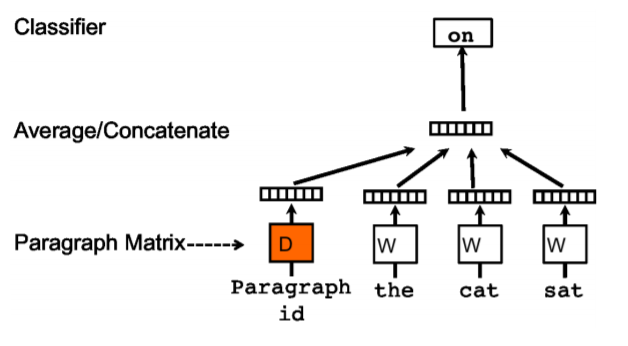

O token de parágrafos funciona memorizando o que está faltando do contexto e por isso o nome Distributed Memory.  

Durante cada etapa do treinamento, um contexto de tamanho fixo é selecionado aleatoriamente de um parágrafo e é calculado o erro para o ajuste dos parâmetros do modelo.

Para a predição, é necessário um vetor de parágrafos de teste para calcular para um outro vetor de parágrafos novo, e então feita a inferência nesse conjunto de teste nunca antes visto pelo modelo. Nesta fase, os parâmetros do modelo e os vetores de palavras **W** estão fixos.

Após o treinamento, o Vetor de Parágrafos pode ser utilizado como *features* em modelos convencionais, como a Regressão Logística, CatBoost, Florestas Aleatórias, XGBoost, etc. 

Algumas vatangens dos Vetores de Parágrafos são o fato deles utilizarem dados não rotulados e fornecerem uma boa generalização do modelo de Skip-Gram para altas dimensões, preservando a semântica e a ordem das palavras. 


### PV-DBOW: Paragraph Vector - Distributed Bag-Of-Words

Essa abordagem, por sua vez, é semelhante ao Skip-Gram do Word2Vec, ou seja, no caso desse modelo, dado uma palavra, o objetivo é prever o contexto. No DBOW, é utilizado o Vetor de Paragráfos para prever a vizinhança de uma determinada palavra, em uma janela fixa.

E também pode ser visto como o modelo acima, sendo que os vetores de palavras **W** são ignorados durante o processo de treinamento e o modleo é forçado a prever palavras escolhidas aleatoriamente do parágrafo.



A imagem abaixo representa um esquema simplificado de como PV-DBOW atua.

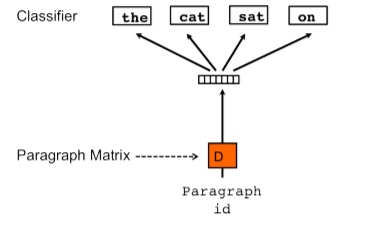

Como vantagem, essa abordagem requere menos armazenamento, sendo assim mais eficiente, uma vez que os vetores de palavras são ignorados.

#Hands-On

Agora vamos ver uma aplicação do Doc2Vec em um conjunto de dados de textos jurídicos com seus status: Ativo, Suspenso ou Arquivado. Comecemos com a parte brevemente descritiva e de pré-processamento dos dados. 

##Importando

Vamos importar as bibliotecas necessárias para a utilização do modelo.

In [ ]:
from google.colab import drive
from IPython.display import clear_output

import re
!pip install ftfy
import ftfy

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

!pip install git+https://github.com/legalnlp21/legalnlp
from legalnlp.clean_functions import *
clear_output()

Célula de comando para fazer o download do modelo Doc2Vec pré-treinado.

In [ ]:
from legalnlp.get_premodel import *
get_premodel('wodc')

Aqui vamos importar o conjunto de dados no qual iremos trabalhar neste tutorial:

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/legalnlp21/legalnlp/main/demo/data_base.csv')
data.drop(columns=['Unnamed: 0'],inplace=True)

E uma breve visualização desses dados:

In [ ]:
data.head()

,text,label
0,Início da Execução Juntado 0008003-11.2018.8.2...,H:Suspenso
1,Ofício Requisitório - Comunicação - Protocolo ...,H:Arquivado
2,Arquivado Provisoriamente aguardando manifestação,H:Suspenso
3,Petição Juntada Juntada a petição diversa - Ti...,H:Ativo
4,Remetidos os Autos para o Arquivo Geral – Devo...,H:Arquivado


Esse conjunto de dados possui 6449 observações e 2 variáveis.

Vamos ver agora se temos dados faltantes:

In [ ]:
print("Quantidade de dados faltantes: ", data.isna().any().sum())

Quantidade de dados faltantes:  0


Isso é bom.Não temos nenhum dado faltante! Porém, vemos que os dados precisam ser limpos antes de serem aplicados no modelo, então vamos aplicar um função que limpa essas observações da coluna $text$.

Aplicamos então a função de limpeza na coluna $text$:

In [ ]:
data['text'] = data['text'].apply(lambda x: clean(x))

E obtemos os dados agora limpos, vamos dar uma olhada:

In [ ]:
str(data.loc[1,'text'])

'ofício requisitório - - comunicação - - protocolo eletrônico - - depre'

## Carregando o Modelo

Agora vamos carregar o modelo Doc2Vec pré-treinado, com abordagem PV-DBOW, de tamanho: $size = 100$ e tamanho de janela: $window\_size = 15$.

In [ ]:
model = Doc2Vec.load('/content/W2V_D2V/w2v_d2v_dbow_size_100_window_15_epochs_20')

Com o modelo carregado, podemos utilizar alguns métodos fornecidos na documentação da biblioteca [Gensim](https://radimrehurek.com/gensim/models/doc2vec.html) para o Doc2Vec.

Com o modelo pré-treinado, podemos inferir novos vetores para novas senteças. 

In [ ]:
model.infer_vector("Textos Jurídicos")

array([-0.10528565, -0.18262663, -0.03521632, -0.25832805,  0.17543973,
        0.15640579, -0.30466983, -0.01432691,  0.1810668 , -0.11091565,
        0.02363857, -0.07944888, -0.02024926, -0.06611905,  0.3174648 ,
       -0.09617839, -0.2178996 ,  0.10965519,  0.0257087 , -0.4584496 ,
       -0.42687213, -0.03835821, -0.21157503, -0.1385506 ,  0.06140572,
       -0.10398644, -0.31388795,  0.03822005,  0.13603339,  0.57265407,
        0.07924065, -0.09288028, -0.14212541, -0.39062363, -0.3334141 ,
       -0.03574827,  0.05532799, -0.37336224,  0.04227997,  0.05472771,
       -0.11553534, -0.24673732, -0.29140761, -0.44976142, -0.05036794,
       -0.06413798, -0.41517362, -0.2297521 , -0.44937548, -0.19306369,
       -0.33786765, -0.1317594 ,  0.21659926,  0.02190926, -0.17928359,
       -0.17962694, -0.04936618,  0.22483177, -0.13268806, -0.48470852,
       -0.16537416,  0.06156918,  0.23803098,  0.14038521,  0.01910947,
       -0.18226822,  0.30911162, -0.07130516, -0.16288355, -0.10

In [ ]:
model.wv.similar_by_word("banco")

[('brasil', 0.7986418008804321),
 ('banco_itaú', 0.6769572496414185),
 ('banco_mercantil', 0.6748969554901123),
 ('bradesco', 0.665328860282898),
 ('banrisul', 0.6483218669891357),
 ('banco_santander', 0.6408952474594116),
 ('santander', 0.6307247877120972),
 ('agência', 0.6243692636489868),
 ('bnb', 0.6186673641204834),
 ('caixa_econômica_federal', 0.604042112827301)]

##De textos para vetores

Primeiramente vamos transformar as $labels$ aplicando o LabelEncoder da biblioteca sklearn.

In [ ]:
encoder = LabelEncoder()
data['encoded'] = encoder.fit_transform(encoder.fit_transform(data['label']))
data.loc[[0, 1, 5]]

,text,label,encoded
0,início da execução juntado [processo] - - cump...,H:Suspenso,2
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0
5,petição juntada nº protocolo : wscb [numero] t...,H:Arquivado,0


Agora vamos inferir os textos para obter vetores.

In [ ]:
from tqdm import tqdm

In [ ]:
def vetor_inferido(texto):

  string = str(texto).split()

  inferido = model.infer_vector(string, steps = 20)
  
  vetores = np.array(inferido)

  return vetores

In [ ]:
data['infered'] = data['text'].apply(lambda x: vetor_inferido(x))

In [ ]:
data.head(5)

,text,label,encoded,infered
0,início da execução juntado [processo] - - cump...,H:Suspenso,2,"[0.15901484, -0.05310801, -0.074882686, -0.034..."
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0,"[-0.019577205, -0.004883687, -0.22685567, 0.07..."
2,arquivado provisoriamente aguardando manifestação,H:Suspenso,2,"[-0.18740115, -0.14128652, -0.07577241, -0.139..."
3,petição juntada juntada a petição diversa - - ...,H:Ativo,1,"[0.11650463, -0.064195886, -0.4042906, 0.30593..."
4,remetidos os autos para o arquivo geral – devo...,H:Arquivado,0,"[-0.01248258, -0.18877189, 0.028325358, -0.098..."


In [ ]:
for i in range(0, 100):
  data[str(i)] = np.vstack(data.loc[:, 'infered'])[:, i]

In [ ]:
data.head(5)

,text,label,encoded,infered,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,início da execução juntado [processo] - - cump...,H:Suspenso,2,"[0.15901484, -0.05310801, -0.074882686, -0.034...",0.159015,-0.053108,-0.074883,-0.034458,-0.005373,-0.080501,-0.182821,0.119119,0.055196,0.259125,0.009539,0.042178,0.016958,0.080522,0.080695,0.270913,-0.127053,0.047654,0.284966,-0.173099,-0.160594,0.054035,-0.320143,-0.022645,-0.036219,-0.085580,-0.235992,0.098988,-0.098574,0.171066,0.210438,0.087716,-0.079889,-0.082605,-0.109303,-0.066298,...,-0.044314,0.175804,-0.240038,-0.104971,0.124861,-0.150507,-0.232100,-0.044469,-0.088703,-0.045805,0.292120,-0.021943,-0.089352,0.180944,-0.304445,-0.047792,0.085511,-0.007238,-0.067446,0.071636,0.034697,0.305743,0.210508,-0.222317,-0.111447,0.154165,-0.125952,0.106836,0.118688,-0.012253,-0.170142,0.080994,0.043833,-0.125351,0.271786,0.056003,0.049653,0.302178,-0.148097,-0.202342
1,ofício requisitório - - comunicação - - protoc...,H:Arquivado,0,"[-0.019577205, -0.004883687, -0.22685567, 0.07...",-0.019577,-0.004884,-0.226856,0.074176,-0.053690,-0.169437,-0.277250,0.211968,0.214354,0.043260,0.062796,0.085195,0.351187,0.073488,0.151877,0.023918,0.206860,0.125027,0.383360,-0.084196,0.058841,-0.059675,-0.470742,0.104927,-0.036640,-0.082263,-0.298866,0.342637,0.208590,0.093055,0.027071,0.108276,-0.154538,-0.143737,-0.127104,-0.120645,...,-0.012286,0.014633,-0.170254,-0.228583,-0.222938,-0.155058,-0.009639,-0.280145,-0.252391,0.043151,0.023850,-0.278942,-0.122721,0.214115,-0.253796,-0.082011,-0.025177,-0.095042,-0.129483,0.195501,0.082223,0.374303,0.257464,0.027813,-0.059674,0.058597,-0.140963,0.270190,-0.142329,-0.056946,-0.158042,0.130731,-0.282701,-0.299768,0.202698,-0.037273,-0.034985,0.118091,0.031472,-0.421063
2,arquivado provisoriamente aguardando manifestação,H:Suspenso,2,"[-0.18740115, -0.14128652, -0.07577241, -0.139...",-0.187401,-0.141287,-0.075772,-0.139834,0.176171,0.146180,-0.163040,0.102759,0.117563,0.060513,-0.034874,-0.146804,0.092238,0.024778,0.062785,0.239271,-0.283511,0.172466,0.391796,0.013824,-0.045004,0.037818,-0.260457,0.063948,0.158922,-0.015334,-0.110322,-0.150336,0.083933,0.132475,0.000263,-0.003379,-0.136355,-0.026075,-0.044384,0.135237,...,0.044897,-0.037070,-0.181015,-0.079972,0.087303,-0.146651,-0.140646,-0.015522,-0.218015,-0.059272,0.105144,-0.085943,-0.076860,-0.182182,-0.224224,0.138178,-0.077676,-0.044266,-0.131346,0.007401,-0.125860,0.213932,0.229486,0.083799,-0.089788,-0.009856,-0.135794,0.116850,-0.085093,-0.226405,-0.123016,-0.153157,-0.265659,-0.130958,0.228673,0.132694,0.070342,0.012898,0.000670,-0.254725
3,petição juntada juntada a petição diversa - - ...,H:Ativo,1,"[0.11650463, -0.064195886, -0.4042906, 0.30593...",0.116505,-0.064196,-0.404291,0.305932,-0.456652,-0.063446,-0.115339,0.130261,-0.235204,0.080352,0.236205,0.357954,0.193611,0.572091,0.308455,-0.240890,0.371009,0.223806,0.427041,-0.043306,-0.002979,0.105390,-0.497103,0.118514,-0.226626,0.013712,-0.482797,0.280578,0.087365,0.343715,0.001037,0.160772,-0.433259,0.046721,-0.164499,0.140923,...,-0.040205,-0.138525,-0.017602,-0.352184,-0.388174,-0.190402,-0.089754,0.184372,-0.066783,-0.386380,0.208632,0.208354,-0.145277,0.289526,-0.150026,0.307580,-0.072741,-0.108624,-0.259369,-0.025968,-0.106889,0.627669,0.274681,-0.043532,-0.033864,-0.006139,0.037337,-0.096050,-0.220781,-0.044377,-0.021952,-0.056881,-0.036172,-0.233938,0.124277,-0.038586,0.148697,0.194018,0.056541,-0.757937
4,remetidos os autos para o arquivo geral – devo...,H:Arquivado,0,"[-0.01248258, -0.18877189, 0.028325358, -0.098...",-0.012483,-0.188772,0.028325,-0.098960,0.151944,0.153390,-0.015755,0.246081,0.030382,-0.280950,0.140821,-0.093654,0.000062,0.134537,0.022711,0.260427,-0.230437,0.171781,0.275213,-0.124504,-0.029528,0.269846,-0.483053,0.176794,-0.002387,0.012160,0.

### Dados de Treino e Teste

In [ ]:
x_train = data.drop(columns = ['encoded', 'text', 'label', 'infered'])[:4500]
x_test = data.drop(columns = ['encoded', 'text', 'label', 'infered'])[4500:]
y_train = data['encoded'][:4500] 
y_test = data['encoded'][4500:]
 
x_train, x_test, y_train, y_test = train_test_split( data.drop(columns = ['encoded', 'text', 'label', 'infered']), data['encoded'], random_state = 42, test_size = 0.3)

In [ ]:
# Tamanhos dos x e y de treino e teste
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4514, 100)
(1935, 100)
(4514,)
(1935,)


##Regressão Logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Instanciando o modelo de Regressão Logística em que será feito o cross-validaton em seguida
log_reg = LogisticRegression(max_iter = 1000,
                             random_state = 42, 
                             solver = 'liblinear')

log_reg

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Definindo o espaço de busca de parâmetros
space = dict()
space['solver'] = ['liblinear']#, 'lbfgs']
space['penalty'] = ['l1']
space['C'] = np.logspace(-3, 3, 100)

rscv = RandomizedSearchCV(log_reg, space, cv = 3, n_jobs = -1, verbose = 1, random_state = 42, n_iter = 30)

# Fazendo o cross-validation
result = rscv.fit(x_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   57.6s finished


In [ ]:
# Melhores hiperparâmetros
print('Melhor acurácia: %s' % result.best_score_)
print('Melhores Hiperparâmetros: %s' % result.best_params_)

Melhor acurácia: 0.8358477062274687
Melhores Hiperparâmetros: {'solver': 'liblinear', 'penalty': 'l1', 'C': 2.1544346900318843}


In [ ]:
log_reg = LogisticRegression(penalty = result.best_params_['penalty'],
                             C = result.best_params_['C'],
                             solver = result.best_params_['solver'],
                             max_iter = 10000,
                             random_state = 42)

# Treinando os modelos com os melhores hiperparâmetros
log_reg.fit(x_train, y_train)

LogisticRegression(C=2.1544346900318843, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l1', random_state=42, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# y hat - predicted values for y
y_pred = log_reg.predict(x_test)
y_pred[:5]

array([1, 0, 1, 0, 1])

In [ ]:
print("A acurácia do modelo é: ", accuracy_score(y_test, y_pred))

A acurácia do modelo é:  0.8366925064599483


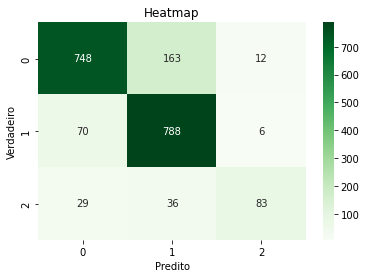

In [ ]:
# Plotando a matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.3g')
plt.title("Heatmap")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       923
           1       0.80      0.91      0.85       864
           2       0.82      0.56      0.67       148

    accuracy                           0.84      1935
   macro avg       0.83      0.76      0.79      1935
weighted avg       0.84      0.84      0.83      1935



##CatBoost - Categorical Boost

In [ ]:
!pip install catboost
clear_output()

In [ ]:
# Importando o CatBoostClassifier 
from catboost import CatBoostClassifier

In [ ]:
# creating validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, stratify = y_train, random_state = 42)

In [ ]:
tunned_model = CatBoostClassifier(
    loss_function = 'MultiClass',
#    thread_count = -1, 
    random_seed=42,
#    iterations=3000,
#    l2_leaf_reg=3,
#    bagging_temperature=1,
#    random_strength=1,
#    leaf_estimation_method='Newton'
)

tunned_model.fit(
    x_train, y_train,
    verbose=500,
    eval_set=(x_val, y_val),
    early_stopping_rounds = 100
)

Learning rate set to 0.111046
0:	learn: 1.0007398	test: 1.0012196	best: 1.0012196 (0)	total: 135ms	remaining: 2m 14s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3850909257
bestIteration = 256

Shrink model to first 257 iterations.


In [ ]:
y_cat_pred = tunned_model.predict(x_test)

In [ ]:
print("A acurácia do modelo é de: ", accuracy_score(y_test, y_cat_pred))

A acurácia do modelo é de:  0.8573643410852713


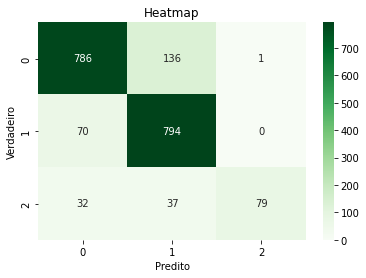

In [ ]:
cm = confusion_matrix(y_test, y_cat_pred)
sns.heatmap(cm, annot = True, cmap = 'Greens', fmt = '.3g')
plt.title("Heatmap")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

In [ ]:
print(classification_report(y_test, y_cat_pred))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       923
           1       0.82      0.92      0.87       864
           2       0.99      0.53      0.69       148

    accuracy                           0.86      1935
   macro avg       0.90      0.77      0.81      1935
weighted avg       0.86      0.86      0.85      1935

